In [9]:
from kaggle.api.kaggle_api_extended import KaggleApi

# Authenticate
api = KaggleApi()
api.authenticate()

In [10]:
#Download dataset
# Replace 'dataset-owner/dataset-name' with the actual dataset you want to download
api.dataset_download_files('rounakbanik/the-movies-dataset', path='./data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset


In [1]:
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Load Datasets

In [4]:
Datasets = pd.read_csv("data/movies_metadata.csv", low_memory=False)
Datasets.head(10)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
5,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
6,False,NaN,58000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,11860,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,...,1995-12-15,0.0,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0
7,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,45325,tt0112302,en,Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses...",...,1995-12-22,0.0,97.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The Original Bad Boys.,Tom and Huck,False,5.4,45.0
8,False,NaN,35000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0
9,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,...,1995-11-16,352194034.0,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0


### Dropping Rows with Missing 'genres' or 'title'

In [5]:
Datasets.dropna(subset=['genres', 'title'], inplace=True)

### Filtering Movies with Non-Empty Genres and Removing Duplicate Titles

In [6]:
modified_movie_data = Datasets[Datasets['genres'].apply(lambda x: len(eval(x)) > 0 if isinstance(x, str) else False)]
modified_movie_data = modified_movie_data.drop_duplicates(subset='title')
print(f"Modified movie data shape : {modified_movie_data.shape}")

Modified movie data shape : (40035, 24)


### If a GPU is available, it sets the device to 'cuda'; otherwise, it sets it to 'cpu'.

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### This code defines a function to preprocess chunks of movie data by extracting and formatting movie titles and genres. The function iterates over each movie in the provided data chunk, converts genre strings to lists, formats the information into strings, and stores it in two separate lists: one for formatted strings (data) and another for tuples of movie titles and genres (movie_info). If any errors occur during processing, the function skips the problematic movie and continues with the next one.

In [8]:
def preprocess_data(movie_data_chunk):
    movie_info = []
    data = []

    for i in range(len(movie_data_chunk)):
        title = movie_data_chunk.iloc[i]['title']
        genres = movie_data_chunk.iloc[i]['genres']
        
        try:
            movies_text = ''
            genres_list = eval(genres)
            genre_names = ', '.join([genre['name'] for genre in genres_list])
            movies_text += "Genres: " + genre_names + '\n'
            movies_text += "Title: " + title + '\n'
            data.append(movies_text)
            movie_info.append((title, genre_names))
        
        except Exception as e:
            continue

    return data, movie_info

### Setting Up for Batch Processing and Iterating Over Data in Chunks

In [9]:
# Preprocess data and extract genres for the first 1000 moviesbat
batch_size = 1000
movie_info = []
complete_data = []
for chunk_start in tqdm(range(0, len(modified_movie_data), batch_size), desc="Processing chunks..."):
    movie_data_chunk = modified_movie_data.iloc[chunk_start:chunk_start+batch_size]
    chunk_movie_data, chunk_movie_info = preprocess_data(movie_data_chunk)
    movie_info.extend(chunk_movie_info)
    complete_data.extend(chunk_movie_data)

# preproces the documents, and create TaggedDocuments
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()),
                              tags=[str(i)]) for i,
               doc in enumerate(complete_data)]

Processing chunks...: 100%|██████████| 41/41 [00:06<00:00,  6.45it/s]


### Build embeddings using Doc2Vec
### defines a function to train a Doc2Vec model, trains the model on tagged movie data, saves the trained model, and then infers vectors for each document in the dataset

### Using the labeled movie data, the train_doc2vec_model method trains a Doc2Vec model to generate 100-dimensional embeddings for every movie. These embeddings serve as the neural network's input features. We are certain that films in comparable genres will be positioned closer to one another in the latent space as a result of the thematic and content similarities between them using our present training setup.

In [10]:
def train_doc2vec_model(tagged_data, num_epochs=20):
    doc2vec_model = Doc2Vec(vector_size=100, min_count=2, epochs=num_epochs)
    doc2vec_model.build_vocab(tqdm(tagged_data, desc="Building Vocabulary"))
    for epoch in range(num_epochs):
        doc2vec_model.train(tqdm(tagged_data, desc=f"Epoch {epoch+1}"), total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
    
    return doc2vec_model

doc2vec_model = train_doc2vec_model(tagged_data)
doc2vec_model.save("doc2vec_model")
document_vectors = [doc2vec_model.infer_vector(
    word_tokenize(doc.lower())) for doc in complete_data]

Epoch 20: 100%|██████████| 40035/40035 [00:02<00:00, 19945.05it/s]


### Extracting unique genre labels:
We utilize a program called MultiLabelBinarizer, which converts genres into a more understandable format for analysis: 0s and 1s, to gather the titles of relevant movies together with their genres. The MultiLabelBinarizer will give a movie a 1 if it fits under a certain genre (such as drama, comedy, or horror); if not, it will give it a 0. Naturally, movies may be in many genres at once. Each row in our dataset will list every exact genre that each movie falls under after it has been converted to binary encoding.

Example: Use "Top Gun Maverick" as an illustration. The film falls within the drama category rather than the comedy or horror categories. Top Gun Maverick is represented by the MultiLabelBinarizer as follows: Drama: 1, Comedy: 0, Horror: 0. We use MultiLabelBinarizer on every movies in our dataset.


### Training a NN for genre_classification:

We will define a neural network with four linear layers activated by ReLUs. Softmax activation is used in the last layer to create probability ratings for different genres. For the multi-label softmax output, you may provide a threshold value if your goal is categorization within the genre spectrum (i.e., analyzing a movie's description to identify its genres). This determines which of the top 'n' genres have the highest odds.

The relevant model training loop, hyperparameter values, and neural network class are as follows:

In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [12]:
# Extracting Genres
genres_list = []
for i, row in modified_movie_data.iterrows():
    genres = [genre['name'] for genre in eval(row['genres'])]
    genres_list.append(genres)

# Binarizing Labels
mlb = MultiLabelBinarizer()
genre_labels = mlb.fit_transform(genres_list)

# Creating Embeddings
embeddings = []
for i, doc in enumerate(complete_data):
    embeddings.append(document_vectors[i])

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(embeddings, genre_labels, test_size=0.2, random_state=42)

In [13]:
# Convert data into array
X_train_np = np.array(X_train, dtype=np.float32)
y_train_np = np.array(y_train, dtype=np.float32)
X_test_np = np.array(X_test, dtype=np.float32)
y_test_np = np.array(y_test, dtype=np.float32)

In [14]:
# Convert  array in to torch tensor 
X_train_tensor = torch.tensor(X_train_np)
y_train_tensor = torch.tensor(y_train_np)
X_test_tensor = torch.tensor(X_test_np)
y_test_tensor = torch.tensor(y_test_np)


### Build NN Classifier

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GenreClassifier(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers=[512, 256, 128], dropout_rate=0.2):
        super(GenreClassifier, self).__init__()
        
        # Ensure hidden_layers is a list
        if not isinstance(hidden_layers, list):
            hidden_layers = [hidden_layers]
        
        # Create a list to hold the layers
        layers = []
        in_features = input_size
        
        for hidden_size in hidden_layers:
            layers.append(self._create_fc_layer(in_features, hidden_size, dropout_rate))
            in_features = hidden_size
        
        # Add the final output layer
        layers.append(nn.Linear(in_features, output_size))
        
        # Use nn.Sequential to create the neural network
        self.network = nn.Sequential(*layers)
        
        # Initialize weights
        self._initialize_weights()

    def _create_fc_layer(self, in_features, out_features, dropout_rate):
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.network(x)

# Assuming `mlb` is your MultiLabelBinarizer instance and `document_vectors` are your embeddings
output_size = len(mlb.classes_)
input_size = len(document_vectors[0])  # Assuming all document vectors have the same length

model = GenreClassifier(input_size=input_size, output_size=output_size, hidden_layers=[512, 256, 128], dropout_rate=0.2).to(device)
model

GenreClassifier(
  (network): Sequential(
    (0): Sequential(
      (0): Linear(in_features=100, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (3): Linear(in_features=128, out_features=20, bias=True)
  )
)

The loss function nn.BCEWithLogitsLoss is used for multi-label classification problems and combines a sigmoid activation with binary cross-entropy loss for numerical stability.

The optimizer optim.Adam is an adaptive learning rate optimizer that updates model parameters using the gradients computed during backpropagation. It is initialized with the model's parameters and a learning rate of 0.001.

In [19]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training loop

In [24]:

epochs = 20
batch_size = 64

train_dataset = TensorDataset(X_train_tensor.to(device), y_train_tensor.to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# List to store the loss for each epoch
epoch_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_losses.append(epoch_loss)  # Record the loss for this epoch
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/20], Loss: 0.0763
Epoch [2/20], Loss: 0.0752
Epoch [3/20], Loss: 0.0742
Epoch [4/20], Loss: 0.0730
Epoch [5/20], Loss: 0.0732
Epoch [6/20], Loss: 0.0725
Epoch [7/20], Loss: 0.0714
Epoch [8/20], Loss: 0.0716
Epoch [9/20], Loss: 0.0714
Epoch [10/20], Loss: 0.0701
Epoch [11/20], Loss: 0.0698
Epoch [12/20], Loss: 0.0693
Epoch [13/20], Loss: 0.0689
Epoch [14/20], Loss: 0.0685
Epoch [15/20], Loss: 0.0676
Epoch [16/20], Loss: 0.0677
Epoch [17/20], Loss: 0.0669
Epoch [18/20], Loss: 0.0669
Epoch [19/20], Loss: 0.0667
Epoch [20/20], Loss: 0.0666


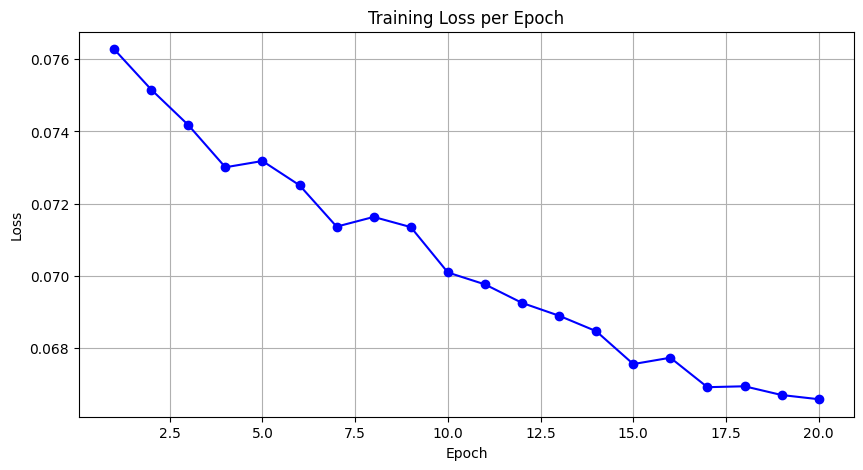

In [25]:
# Plotting the loss with respect to epochs
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.show()

That's it! We've successfully trained a neural network for our genre classification task.

You can check how well the model is classifying genres, using the f-1_score, as follows:

In [26]:
from sklearn.metrics import f1_score

model.eval()
with torch.no_grad():
    X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)  # Move test data to device
    outputs = model(X_test_tensor)
    test_loss = criterion(outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')


thresholds = [0.1] * len(mlb.classes_)
thresholds_tensor = torch.tensor(thresholds, device=device).unsqueeze(0)

# Convert the outputs to binary predictions using varying thresholds
predicted_labels = (outputs > thresholds_tensor).cpu().numpy()

# Convert binary predictions and actual labels to multi-label format
predicted_multilabels = mlb.inverse_transform(predicted_labels)
actual_multilabels = mlb.inverse_transform(y_test_np)

# Print the Predicted and Actual Labels for each movie
for i, (predicted, actual) in enumerate(zip(predicted_multilabels, actual_multilabels)):
    print(f'Movie {i+1}:')
    print(f'    Predicted Labels: {predicted}')
    print(f'    Actual Labels: {actual}')

Test Loss: 0.0807
Movie 1:
    Predicted Labels: ('Music', 'Romance')
    Actual Labels: ('Drama', 'Music')
Movie 2:
    Predicted Labels: ('Comedy', 'Romance')
    Actual Labels: ('Comedy', 'Romance')
Movie 3:
    Predicted Labels: ('Action', 'Crime')
    Actual Labels: ('Action', 'Crime')
Movie 4:
    Predicted Labels: ('Science Fiction',)
    Actual Labels: ('Action', 'Science Fiction')
Movie 5:
    Predicted Labels: ('Drama', 'War')
    Actual Labels: ('War',)
Movie 6:
    Predicted Labels: ('Comedy',)
    Actual Labels: ('Comedy',)
Movie 7:
    Predicted Labels: ('Comedy',)
    Actual Labels: ('Drama',)
Movie 8:
    Predicted Labels: ('Comedy', 'Drama')
    Actual Labels: ('Comedy', 'Drama')
Movie 9:
    Predicted Labels: ('Drama', 'Foreign')
    Actual Labels: ('Drama', 'Foreign')
Movie 10:
    Predicted Labels: ('Action', 'Adventure', 'Fantasy', 'Science Fiction')
    Actual Labels: ('Action', 'Adventure', 'Fantasy', 'Science Fiction')
Movie 11:
    Predicted Labels: ('Drama',)


### Compute F1-score

In [27]:
# Compute F1-score
f1 = f1_score(y_test_np, predicted_labels, average='micro')
print(f'F1-score: {f1:.4f}')

F1-score: 0.8579


### Saving the trained model

In [28]:
torch.save(model.state_dict(), 'trained_model.pth')

### Implementing our movie RecSys

implement a movie recommendation system step-by-step, focusing on user queries and using similarity metrics to recommend similar movies.

Steps to Implement the Movie Recommendation System:
Preprocess User Input: Allow users to input a movie title.
Retrieve Embeddings: Retrieve the Doc2Vec embeddings for the query movie.
Calculate Similarities: Compute the similarity between the query movie's embedding and all other movie embeddings.
Recommend Movies: Identify and recommend the top 'n' similar movies.

### Setting Up and Using LanceDB Vector Database open source, fast, has high-level security (our data is local), versioning, and built-in search capabilities.
1: Install LanceDB:

Ensure you have LanceDB installed

2 Store Doc2Vec Embeddings:

Create a table in LanceDB to store the movie embeddings, titles, and genres.
Q3 uery the Database:

Use LanceDB's built-in search capabilities to retrieve and recommend movies based on the query movie's embedding.

In [29]:
import lancedb
import numpy as np
import pandas as pd

data = []

for i in range(len(movie_info)):  # Iterate over movie_info, not modified_movie_data
    embedding = document_vectors[i]
    title, genres = movie_info[i]  # Correctly access title and genres from movie_info
    data.append({"title": title, "genres": genres, "vector": embedding})

db = lancedb.connect(".db")
tbl = db.create_table("doc2vec_embeddings", data, mode="Overwrite")
db["doc2vec_embeddings"].head()

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2024-07-28T21:59:21Z WARN  lance::dataset] No existing dataset at /workspaces/Build-Recommendations-by-using-a-Vector-Database/.db/doc2vec_embeddings.lance, it will be created


pyarrow.Table
title: string
genres: string
vector: fixed_size_list<item: float>[100]
  child 0, item: float
----
title: [["Toy Story","Jumanji","Grumpier Old Men","Waiting to Exhale","Father of the Bride Part II"]]
genres: [["Animation, Comedy, Family","Adventure, Fantasy, Family","Romance, Comedy","Comedy, Drama, Romance","Comedy"]]
vector: [[[0.05277276,0.030128464,0.14898333,-0.24831939,0.17604543,...,0.36931086,0.017491642,-0.24738869,0.051797558,0.16139811],[-0.18401422,-0.017022228,0.21198502,-0.19916458,-0.007266404,...,0.13360061,-0.011172549,-0.118220255,0.005203327,0.13695283],[0.055286933,-0.021927806,0.13815816,-0.30995306,-0.044360537,...,0.27547604,-0.08237365,-0.025830016,-0.064845055,0.12737922],[-0.16699716,-0.030699356,-0.008681381,-0.28479603,-0.014245965,...,0.13076964,-0.10488954,-0.040287815,0.07736818,0.15843536],[-0.031266086,0.17244966,0.16599366,-0.1773075,-0.10458249,...,0.095748894,-0.16460054,-0.09130962,-0.016225195,0.10292848]]]

### Using Doc2Vec embeddings to surface relevant recommendations:
We initially use our trained neural network to forecast the genres of a given query movie. Next, we apply a suitable SQL filter to our movie database, limiting its inclusion to just those films that fit into at least one of the anticipated categories. Then, using this filtered selection, we run a vector similarity search to find the most related movies based on their vector representations. This methodology guarantees the relevance and customization of our movie recommendations; our selections will not only have vector qualities in common with the query movie, but also share genre preferences.

In [30]:
# The function get_genres_for_query takes a query embedding and predicts the genres associated with that query using a trained neural network model.

def get_genres_for_query(model, query_embedding, mlb, thresholds, device):
    model.eval()
    with torch.no_grad():
        query_tensor = torch.tensor(query_embedding, dtype=torch.float32).unsqueeze(0).to(device)
        outputs = model(query_tensor)
        thresholds = [0.001] * len(mlb.classes_)
        thresold_tensor = torch.tensor(thresholds, device=device).unsqueeze(0)
        predicted_labels = (outputs >= thresold_tensor).cpu().numpy()
        predicted_multilabels = mlb.inverse_transform(predicted_labels)
        return predicted_multilabels

In [31]:
# The function movie_genre_prediction takes a movie title as input and predicts the genres associated with that movie using a trained neural network model and its corresponding embedding.

def movie_genre_prediction(movie_title):
    movie_index = modified_movie_data.index[modified_movie_data['title'] == movie_title].tolist()[0]
    query_embedding = document_vectors[movie_index]
    predicted_genres = get_genres_for_query(model, query_embedding, mlb, [0.1] * len(mlb.classes_), device=device)
    return predicted_genres

### Our RecSys is now complete. Let's test it by generating some recommendations, using "Toy Story" as our query.

In [33]:
# The get_recommendations function takes a movie title as input and returns a list of recommended movie titles based on their vector similarity and genre similarity to the input movie.

def get_recommendations(title):
    pd_data = pd.DataFrame(data)
    title_vector = pd_data[pd_data["title"] == title]["vector"].values[0]
    predicted_genres = movie_genre_prediction(title)
    genres_movie = predicted_genres[0]  # Assuming predicted_genres is available

    genre_conditions = [f"genres LIKE '%{genre}%'" for genre in genres_movie]
    where_clause = " OR ".join(genre_conditions)

    result = (
        tbl.search(title_vector)
        .metric("cosine")
        .limit(10)
        .where(where_clause)
        .to_pandas()
    )
    return result[["title"]]

### Final Get recommendations

In [35]:
get_recommendations("Toy Story")

,title
0,Toy Story
1,Lilo & Stitch
2,The SpongeBob SquarePants Movie
3,Puella Magi Madoka Magica the Movie Part I: Be...
4,Ivan Tsarevich & the Grey Wolf
5,This Unnameable Little Broom
6,Piper
